# Sample portfolio 1

This notebook runs through the library on the one of the examples in the __'sample_portfolio2'__

At the end we optimize to get the results of all the 8 different views

First we import everything

In [1]:
import pandas as pd 
import numpy as np
from entropy_pooling import views
from entropy_pooling import entropy_minimizer
from entropy_pooling import markoviz_optimizer

Then we get the data

In [2]:
data_raw = pd.read_excel("data/data.xlsx").dropna(axis=1, how='all')
weights = data_raw[["Weight"]]
scenarios = data_raw.drop(columns = ["Weight"])/100

We load the vies

In [3]:
(A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx",
                       views_subsheet_name = 2);

We create the posterior distribution

In [4]:
c = 1
p = np.array(weights)
m,n = p.shape

posterior = entropy_minimizer.full_confidence_posterior(p, A, b, C, d, verbose = True)
weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)



Results
Optimal dual variable values:  [ 2.81186418 -0.97813745]
Jacobian matrix at optimum [-3.06266828e-06 -4.02891634e-07]


We get the deltas and create the asset space. Additionally, we import the additional constraints for the markoviz optimization.

We manually define to size of funds that can be used

In [5]:
total = 417000000

deltas, asset_names = markoviz_optimizer.load_asset_deltas("data/sample_portfolio2_deltas.xlsx")

asset_scenarios = markoviz_optimizer.asset_scenarios(scenarios, deltas, asset_names)

loaded_constraints = pd.read_excel("data/sample_portfolio2_constrs.xlsx").dropna(axis=1, how='all')
manual_constraints = (loaded_constraints.iloc[:,:-2],
                      loaded_constraints.iloc[:,-2],
                      loaded_constraints.iloc[:,-1])

And finally we do markowitz optimization on the posterior distribution and plot the outcome.

We minimize the volatility at return $\mu_0 = 0.5$ and do not allow for shorting.

The optimization was succesful: True
Global Equities: 7098568.0
DM Equities: 7098570.0
EM Equities: 7098538.0
European Equities: 7098566.0
US Equities: 7098575.0
EUR Money Markets: 53253618.0
EUR Government Bonds: 86221436.0
EUR Covered Bonds: 53253596.0
EUR Investment Grade Corporate Bonds: 53253577.0
European High Yield Corporate Bonds: 41700000.0
EMD Hard Currency: 53253545.0
Hedge Funds: 20285771.0
Listed Private Equity: 20285640.0
Technical Provisions: 1.0
IR Hedges: 1.0


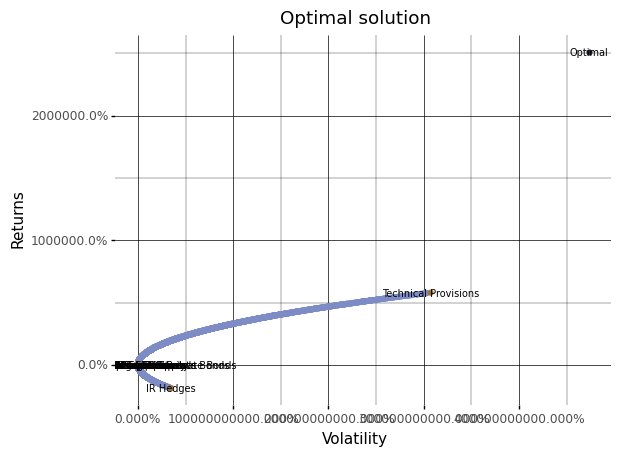

In [6]:
optimal_x = markoviz_optimizer.optimizer(asset_scenarios,
                                         weighted_posterior,
                                         mu_0 = 0,
                                         manual_constraints = manual_constraints,
                                         visualize = True,
                                         verbose = 1).x
for i, col in enumerate(asset_scenarios.columns):
  #print("{}: {}%".format(col, np.round(optimal_x[i]*100,decimals = 1)))
  print("{}: {}".format(col, np.round(optimal_x[i],decimals = 0)))

We can compare the optimization of the posterior distribution with the prior below

The optimization was succesful: False
The optimization was terminated due to: 
Positive directional derivative for linesearch
Global Equities: 0.0
DM Equities: 0.0
EM Equities: 0.0
European Equities: 0.0
US Equities: 0.0
EUR Money Markets: 0.0
EUR Government Bonds: 0.0
EUR Covered Bonds: 0.0
EUR Investment Grade Corporate Bonds: 0.0
European High Yield Corporate Bonds: 0.0
EMD Hard Currency: 0.0
Hedge Funds: 0.0
Listed Private Equity: 1.0
Technical Provisions: 0.0
IR Hedges: 0.0


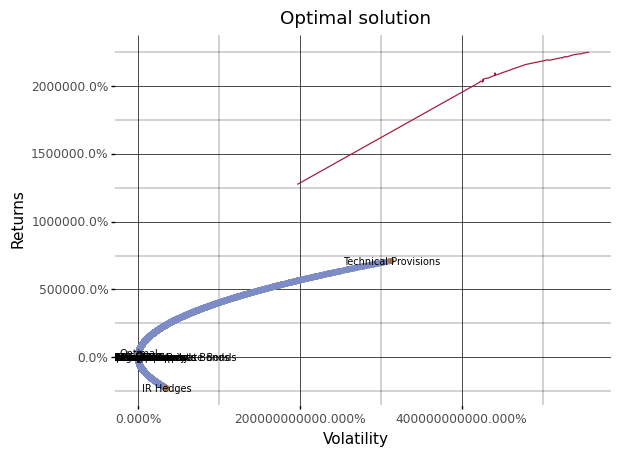

In [7]:
optimal_x = markoviz_optimizer.optimizer(asset_scenarios,
                                         weights,
                                         mu_0 = 0.01*total,
                                         manual_constraints = manual_constraints,
                                         visualize = True,
                                         verbose = 1).x

for i, col in enumerate(asset_scenarios.columns):
  #print("{}: {}%".format(col, np.round(optimal_x[i]*100,decimals = 1)))
  print("{}: {}".format(col, np.round(optimal_x[i],decimals = 0)))

In [84]:
result = pd.DataFrame(columns = range(8), index =['Result','Optimal risk', 'Expected return', *asset_names])
weights_pos = pd.DataFrame(columns = range(8))
for i in range(8):
  (A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx", views_subsheet_name = i);
  c = 1                 #scenario probability
  p = np.array(weights)
  m,n = p.shape

  posterior = entropy_minimizer.full_confidence_posterior(p, A,b,C,d)
  weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)
  weights_pos.iloc[:,i] = weighted_posterior
  optimal = markoviz_optimizer.optimizer(asset_scenarios,
                                         weighted_posterior,
                                         mu_0 = 0,
                                         manual_constraints = manual_constraints,
                                         visualize = False,
                                         verbose = 0)
  probabilities_reshaped = np.asarray(weighted_posterior).reshape(-1,)
  mu = np.average(asset_scenarios, axis=0, weights = probabilities_reshaped)
  result.iloc[0,i] = optimal.success
  result.iloc[1,i] = np.round(optimal.fun, decimals= 0)
  result.iloc[2,i] = np.round(optimal.x @ mu, decimals= 0)
  result.iloc[3:,i] = np.round(optimal.x, decimals= 0)
result
  

,0,1,2,3,4,5,6,7
Result,True,False,True,True,True,True,True,True
Optimal risk,65764.0,1815.0,68788.0,72441.0,74323.0,64052.0,71495.0,65687.0
Expected return,10351.0,-3020.0,25083.0,10380.0,22455.0,23742.0,15907.0,25515.0
Global Equities,9433187.0,0.0,7098568.0,11969347.0,11628845.0,8598003.0,10828061.0,9332509.0
DM Equities,11243957.0,0.0,7098570.0,13581847.0,12674033.0,9699488.0,13088789.0,10358228.0
EM Equities,11.0,0.0,7098538.0,730262.0,-0.0,5533.0,-0.0,632454.0
European Equities,12.0,0.0,7098566.0,-0.0,0.0,2513.0,-0.0,3806748.0
US Equities,19603132.0,1.0,7098575.0,15418159.0,17397094.0,18188074.0,17783059.0,17570061.0
EUR Money Markets,52318109.0,0.0,53253618.0,52125113.0,52125352.0,52661275.0,52125090.0,50968689.0
EUR Government Bonds,84328843.0,0.0,86221436.0,83400194.0,83400044.0,86602071.0,83400067.0,89395650.0


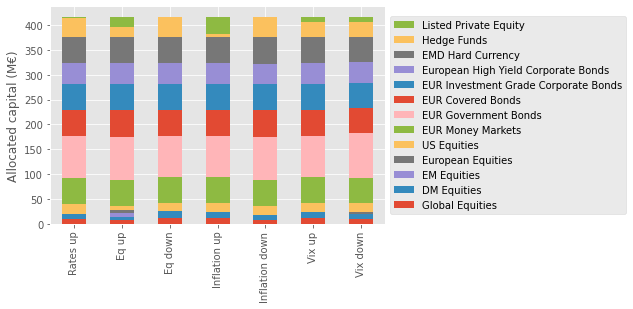

In [120]:
plt.style.use('ggplot')
#labels = result.columns[result. == 'True']
result.columns = ['Rates up', 'Rates down', 'Eq up', 'Eq down', 'Inflation up', 'Inflation down', 'Vix up', 'Vix down']
filtered_res = result.iloc[3:-2, [0,2,3,4,5,6,7]]
#print(filtered_res)
#titles = ['Rates up', 'Rates down', 'Eq up', 'Eq down', 'Inflation up', 'Inflation down', 'Vix up', 'Vix down']
filtered_res = filtered_res / 1e6
ax = filtered_res.T.plot.bar(stacked=True,ylabel="Allocated capital (M€)")#,figsize=(6.4*1.5, 4.8*1.5))
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles[::-1], labels[::-1], loc='center left',bbox_to_anchor=(1.0, 0.5));
#leg.legendHandles = reversed(ax.legendHandles)
#labels = ax.legendLabels
fig = ax.get_figure()
fig.savefig('stacked_barplot.pdf',bbox_inches='tight')
        

In [9]:
from plotnine import ggplot, geom_area, aes, scale_y_continuous

(A,b,C,d) = views.load(views_sheet_name = "data/sample_portfolio2_views.xlsx",
                       views_subsheet_name = 2);
precision = 4
result = pd.DataFrame(columns = range(precision), index =['Result','Optimal risk', 'Expected return', *asset_names])
for i in range(precision):
  c = 1                 #scenario probability
  p = np.array(weights)
  m,n = p.shape

  posterior = entropy_minimizer.full_confidence_posterior(p, A,b,C,d)
  weighted_posterior = entropy_minimizer.confidence_weighted_posterior(p, posterior, c)
  optimal = markoviz_optimizer.optimizer(asset_scenarios,
                                         weighted_posterior,
                                         mu_0 = i*(0.00001*2)*total,
                                         manual_constraints = manual_constraints,
                                         visualize = False,
                                         verbose = 0)
  probabilities_reshaped = np.asarray(weighted_posterior).reshape(-1,)
  mu = np.average(asset_scenarios, axis=0, weights = probabilities_reshaped)
  result.iloc[0,i] = optimal.success
  if optimal.success:
    result.iloc[1,i] = np.round(optimal.fun, decimals= 0)
    result.iloc[2,i] = np.round(optimal.x @ mu, decimals= 0)
    result.iloc[3:,i] = np.round(optimal.x, decimals= 0)
  else:
    result.iloc[1,i] = 0
    result.iloc[2,i] = 0
    result.iloc[3:,i] = np.zeros_like(result.iloc[3:,i])

melted= result.iloc[3:,:].melt(ignore_index=False).reset_index()


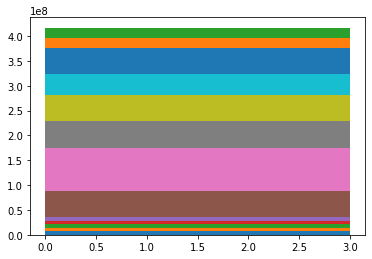

In [71]:
import matplotlib.pyplot as plt
result_T = result.T
result_T = result_T.iloc[:,3:]
result_T = np.array(result_T.T)
#plt.stackplot([0,1,2],[4,4,6],[8,6,7], colors =['r', 'c'])
plt.stackplot([0,1,2,3], result_T.astype(int))
#plt.stackplot([0,1,2,3], np.array(result_T[['US Equities']].T)[0].tolist(), np.array(result_T[['Global Equities']].T)[0].tolist())

In [60]:
def layers(n, m):
    """
    Return *n* random Gaussian mixtures, each of length *m*.
    """
    def bump(a):
        x = 1 / (.1 + np.random.random())
        y = 2 * np.random.random() - .5
        z = 10 / (.1 + np.random.random())
        for i in range(m):
            w = (i / m - y) * z
            a[i] += x * np.exp(-w * w)
    a = np.zeros((m, n))
    for i in range(n):
        for j in range(5):
            bump(a[:, i])
    return a


d = layers(3, 100)
print(type(d.T))
#fig, ax = plt.subplots()
#ax.stackplot(range(100), d.T, baseline='wiggle')
#plt.show()

<class 'numpy.ndarray'>


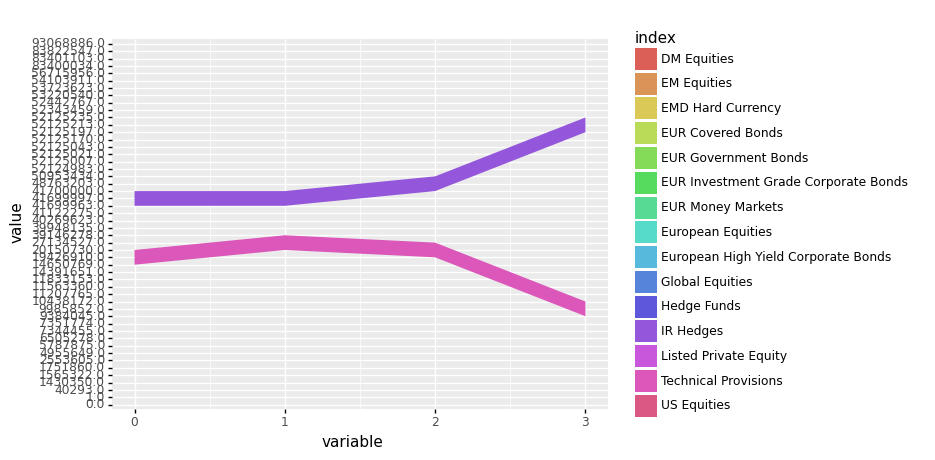

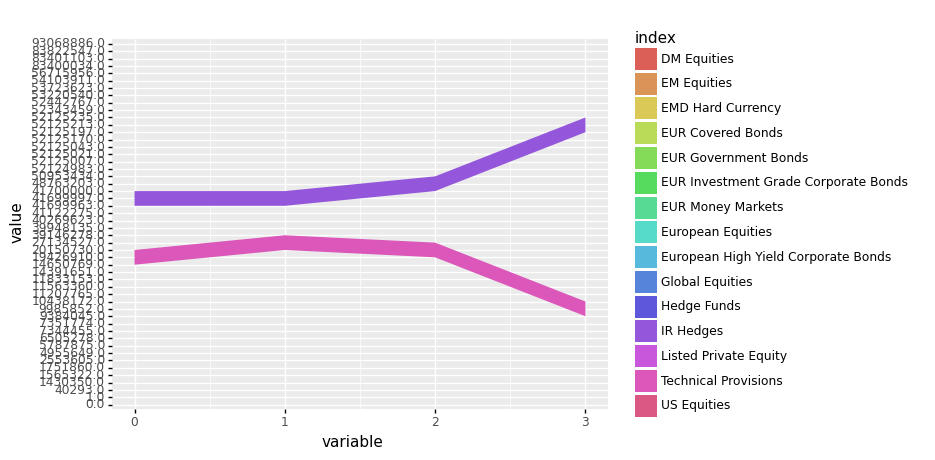

In [ ]:
plot = (ggplot(data = melted, mapping =  aes( x='variable', fill='index', y='value')) 
        + geom_area())
plot.draw()

In [ ]:
result

,0,1,2,3
Result,True,True,True,True
Optimal risk,63985.0,64823.0,65058.0,72675.0
Expected return,21617.0,22428.0,22518.0,25020.0
Global Equities,4955649.0,9985852.0,10438172.0,7344455.0
DM Equities,6505278.0,11563360.0,11833153.0,7351774.0
EM Equities,40293.0,-0.0,0.0,11207765.0
European Equities,1565322.0,-0.0,0.0,5787875.0
US Equities,14650769.0,20150730.0,19426910.0,9384045.0
EUR Money Markets,54103911.0,52125043.0,52125235.0,48763203.0
EUR Government Bonds,93068886.0,83400034.0,83401103.0,83822547.0
